# Resiliency tool

In [1]:
import reXplan as rx
import pandas as pd
import numpy as np
from datetime import date as dt_date

from pandapower.plotting.plotly import simple_plotly, vlevel_plotly, pf_res_plotly
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pandapower.plotting.plotly import simple_plotly, vlevel_plotly, pf_res_plotly
from utils import * # pplotting functions

import warnings
warnings.simplefilter("ignore") # warning are ignored for now


## Network initialization

In [2]:
simulationName = 'basic_example_tim';
network = rx.network.Network(simulationName);
simulation = rx.simulation.Sim(simulationName);

Duration of simulation is 40 timesteps.
Start of hazard at timestep 12, end at timestep 17 (duration: 5 timesteps)


#### Fragility Curves are automatically generated once the network object is created

### Or Plot all the fragility curves in the database

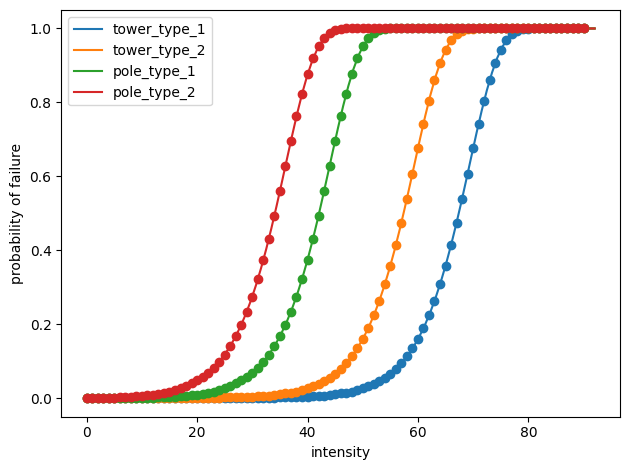

In [3]:
xnew = np.linspace(0, 92, num=100, endpoint=True)
fig, ax = rx.fragilitycurve.plotFragilityCurves(network.fragilityCurves, xnew)

### Method 1: Generate a hazard element by reading a .nc file

In [ ]:
network.event.hazardFromNC('sythetic_data.nc')
fig, ax = network.event.plot(10, projection='cyl', edge_pad=0)

### Method 2: Generate a hazard element by reading a trajectory csv file

In [ ]:
network.event.hazardFromTrajectory('trajectory.csv', 
                                   max_intensity=60., max_radius=50., 
                                   sdate = dt_date(2022,4,1), edate = dt_date(2022,4,3), 
                                   geodata1 = rx.network.GeoData(47.4,5.8), geodata2 = rx.network.GeoData(54.9,15.0),
                                   delta_km=10, frequency='1H')

fig, ax = network.event.plot(10, projection='cyl', edge_pad=0)

### Method 3: Generate a static hazard element by providing the location of the epicenter

In [ ]:
network.event.hazardFromStaticInput('static_event.nc',
                                    max_intensity=90, max_radius=100,
                                    sdate = dt_date(2022,4,1), edate = dt_date(2022,4,3),
                                    geodata1 = rx.network.GeoData(47.4,5.8), geodata2 = rx.network.GeoData(54.9,15.0),
                                    delta_km=10,
                                    epicenter_lat=50, epicenter_lon=9,
                                    frequency='1H', epicenter_radius=1, epicenter_intensity=1)

fig, ax = network.event.plot(10, projection='cyl', edge_pad=0)

### For Methods 1-3: Use simulation.initialize_model_sh to generate outage schedule

In [ ]:
simulation.initialize_model_sh(network, iterationNumber=10)
simulation.run(network,
                #iterationSet = [1],
                run_type = 'pm_ac_opf', 
                delta = 1e-16, 
                saveOutput = True)

In [ ]:
simulation.results.loc[:,:,:,'network',:]

### Method 4: Simulate multiple events according a given return period

In [6]:
simulation.initialize_model_rp(network=network,
                               ref_return_period="rp2",
                               mc_iteration_factor=2,
                               max_mc_iterations=1000,
                               cv=0.1,
                               nStrataSamples=10000,
                               #x_min=0.722, x_max=1.5
                              )

Lowest return period intensity: 16.5
Highest return period intensity: 93.75


R[write to console]: Error in (function (df, id, X, Y, domainvalue)  : 
  Y variable NULL not in the frame variables



RRuntimeError: Error in (function (df, id, X, Y, domainvalue)  : 
  Y variable NULL not in the frame variables


In [ ]:
sns.set(rc={'figure.figsize':(4,4)})
for rp in network.returnPeriods.keys():
    sns.lineplot(x=network.returnPeriods[rp].x_data, y=network.returnPeriods[rp].y_data)

In [ ]:
simulation.stratResults

TypeError: 'NoneType' object is not subscriptable

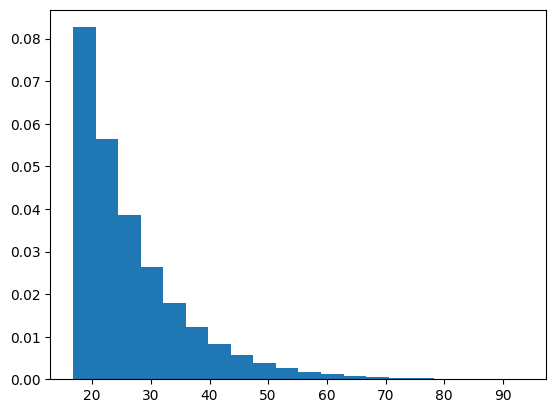

In [5]:
plt.hist(simulation.samples, density=True, bins=20)
for b in np.append(simulation.stratResults["Upper_X1"].values, simulation.stratResults["Lower_X1"].values[0]):
    plt.axvline(x = b, color = 'r')

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = simulation.failureProbs[simulation.failureProbs['element type']=='Line']
sns.lineplot(data=df, x='event intensity', y='failure probability', hue='power element')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
simulation.failureProbs[(simulation.failureProbs['element type']=='Generator') & (simulation.failureProbs['iteration']==4)]

## Launching montecarlo simulations
Optimal power flow (40 steps) over 8 montercalo iterations divided into 4 stratas.

In [ ]:
simulation.run(network, iterationSet = None, time = None, run_type = 'pm_ac_opf', delta = 1e-16, saveOutput = True)

In [ ]:
simulation.results.loc[:,:,:,'network',:]

## Iterations metrics

In [ ]:
df = pd.read_csv(rx.config.path.engineDatabaseFile(simulationName), index_col = [0, 1, 2, 3, 4]) # read database with results
df = filter_non_converged_iterations(df) # filterining non-converged iterations


In [ ]:
df_line = group_by(df.loc[1], 'sum', 'iteration', 'field', 'type').loc[:,:,'line']
df_line_quantiles = invert(get_quantiles_on_iterations(df_line, [0.05,0.5,0.95]))
df_line = invert(df_line)

In [ ]:
df_montecarlo = pd.read_csv(rx.config.path.engineDatabaseFile(simulationName), index_col = [0, 1, 2, 3, 4])

### Number of lines in service

In [ ]:
px.line(df_line, x=df_line.index, y = 'in_service', color = 'iteration')

In [ ]:
px.line(df_line_quantiles, x=df_line_quantiles.index, y = 'in_service', color = 'quantile')

In [ ]:
df_load = group_by(filter(df, type = 'load'), 'sum', 'iteration', 'field', 'type')
df_load_quantiles = invert(get_quantiles_on_iterations(df_load, [0.05, 0.25, 0.5, 0.75, 0.95]))
# df_load = invert(df_load) 
# df_load['loss_of_load_p_percentage'] = (df_load['loss_of_load_p_mw'])/df_load['max_p_mw'] *100
df_load_quantiles['loss_of_load_p_percentage'] = (df_load_quantiles['loss_of_load_p_mw'])/df_load_quantiles['max_p_mw'] *100

In [ ]:
px.line(df_load_quantiles, x=df_load_quantiles.index, y = 'loss_of_load_p_percentage', color = 'quantile')

In [ ]:
df_network = invert(filter(df, type = 'network')) # filter network fields and invert for plotting
px.scatter(df_network, x=df_network.index, y= 'energy_not_served_mwh' )

## Montercalo metrics

In [ ]:
df_network_condensed = filter(df, type = 'network').sum(axis = 1) # sum over timesteps

In [ ]:
df_network_condensed_ = invert(df_network_condensed)
px.histogram(df_network_condensed_, x='energy_not_served_mwh', histnorm='probability')

In [ ]:
statistics= df_network_condensed.groupby('field').mean() # average over iterations
EENS = statistics['energy_not_served_mwh']
LOLE = statistics['loss_of_load_p_duration_h']
print(f'EENS : {EENS.round(2)} MWh, LOLE : {LOLE.round(2)} h')

## Survivability
Probability of supplying at minimum percentage of the load.

In [ ]:
crt_loss_of_load = 30 
df_loss_of_load = df.loc[:,:,"loss_of_load_p_percentage","network"]
Survivability = pd.DataFrame(1 - (df_loss_of_load > crt_loss_of_load).sum() / df_loss_of_load.index.levels[0].size, columns = ['base case'])

#df_aux = pd.read_csv(rx.config.path.engineDatabaseFile('basic_example_v1'), index_col = [0, 1, 2, 3, 4])
#df_loss_of_load_aux = df_aux.loc[:,"loss_of_load_p_percentage","network"]
#Survivability['line 10 reinforced'] = 1 - (df_loss_of_load_aux > crt_loss_of_load).sum() / df_loss_of_load_aux.index.levels[0].size

#df_aux = pd.read_csv(rx.config.path.engineDatabaseFile('basic_example_v2'), index_col = [0, 1, 2, 3, 4])
#df_loss_of_load_aux = df_aux.loc[:,"loss_of_load_p_percentage","network"]
#Survivability['line 2 reparing time improved'] = 1 - (df_loss_of_load_aux > crt_loss_of_load).sum() / df_loss_of_load_aux.index.levels[0].size

In [ ]:
px.line(Survivability).update_layout(xaxis_title="time", yaxis_title="Survivability")

In [ ]:
df_line = group_by(filter(df, type = 'line'), 'mean','strata', 'iteration', 'field','id') # mean in this case does not have any effect as the groupying levels are the initial ones
df_line = invert(df_line)
# df_line = df_line.loc[df_line.index > '2022-01-01 12:00:00']

fig = go.Figure() # --> put in a function (?)

ids = df_line['id'].drop_duplicates().to_list()

for id in ids:
    fig.add_trace(go.Violin(x=df_line['id'][df_line['id'] == id],
                            y=df_line['loading_percent'][df_line['id'] == id],
                            name=id,
                            box_visible=False,
                            meanline_visible=True,
                            side='positive',
                            orientation = 'v'
                           )
                 )
fig.update_layout(width=1000, height=500)
fig.show()

In [ ]:
df_bus =invert(filter(df, type = 'bus'))
fig = go.Figure()

ids = df_bus['id'].drop_duplicates().to_list()

for id in ids:
    fig.add_trace(go.Violin(x=df_bus['id'][df_bus['id'] == id],
                            y=df_bus['vm_pu'][df_bus['id'] == id],
                            name=id,
                            #box_visible=True,
                            meanline_visible=True,
                            side='positive',
                            orientation = 'v'
                           )     
                 )
fig.update_layout(width=1000, height = 500)
fig.show()